In [63]:
# all necessary includes

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

import os
import nltk
# nltk.download('stopwords')

In [80]:
# additional functions

garbage_words = stopwords.words('english') + stopwords.words('russian')


# will split dataframe into samples with same proportion of each document class
def SplitTrainSample(dataframe, fraction=0.7):
    '''
    1) to form arrays for each document class
    2) to split each class by np.split
    3) to shuffle rows in resulting dataframe1 and dataframe2
    '''
    types = set(dataframe['target'])
    print(types)
    dataframes = [dataframe[dataframe['target'] == doc_type] for doc_type in types]
    splited = [np.split(df.sample(frac=1), [int(fraction * len(df))]) for df in dataframes]
    test = [df[0] for df in splited]
    train = [df[1] for df in splited]
    return pd.concat(train).sample(frac=1), pd.concat(test).sample(frac=1)


def ClearText(text, garbage_words):
    result = [word for word in text.lower().split() if word not in garbage_words]
    return ' '.join(result)


def CreateVectorizer(ngram_range, max_features):
    return CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )



def TrainRandomForestClassifier(dataframe, n_estimators=300):
    ngram_range = (1, 3)
    max_features = 50000

    vectorizer = CreateVectorizer(ngram_range, max_features)
    X_train, Y_train = dataframe['X'], dataframe['target']
    
    X_train = vectorizer.fit_transform(X_train)
    #print(X_train.shape)
    #print(type(X_train))
    # X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)
    model = model.fit(X_train, Y_train)
    return vectorizer, model


def CalculateAccuracy(ds, confidence_level):
    ds['predict'] = model.predict(vectorizer.transform(ds['X']))
    ds['confidence'] = np.transpose(np.amax(model.predict_proba(vectorizer.transform(ds['X'])), axis=1))

    precision = round(100 * len(ds[(ds['confidence'] >= confidence_level) & (ds['target'] == ds['predict'])]) / len(ds), 2)
    to_validate = round(100 * len(ds[(ds['confidence'] < confidence_level)]) / len(ds), 2)
    return precision, to_validate, confidence_level


def BuildDataFrame(cur_folder, doc_types, file_names, doc_texts, name=''):
    files = os.listdir()
    cur_name = name[:]
    if len(cur_name) != 0:
        cur_name += '-'
    cur_name += cur_folder
    if 'text_layer' in files:
        files.remove('text_layer')
        print('in', cur_name)
        
    folders = [file for file in files if '.' not in file]
    
    for folder in folders:
        os.chdir(folder)
        BuildDataFrame(folder, doc_types, file_names, doc_texts, cur_name)
        os.chdir('..')
    if len(folders) == 0:
        for file in files:
            text_layer = ''
            if 'text_layer' in os.listdir():
                try:
                    with open('./text_layer/' + file.split('.')[0] + '.txt') as f:
                        text_layer = f.read()
                except:
                    NOT_FOUND.append((file, cur_name))
            if len(text_layer) > 0:
                doc_texts.append(text_layer)
                doc_types.append(cur_name)
                file_names.append(file)
        

In [3]:
# read input
NOT_FOUND = []
doc_types, file_names, doc_texts = [], [], []

dataset_path = 'for training'
os.chdir(dataset_path)
BuildDataFrame('', doc_types, file_names, doc_texts)
os.chdir('..')
df = pd.DataFrame({'file_name': file_names, 'doc_type': doc_types, 'doc_text' : doc_texts})
# print(df)

in ad-error
in ad-invoice-first
in ad-invoice-multi
in ad-statement-first
in ad-statement-multi
in ad-upd-first
in ad-upd-multi
in ad-waybill-first
in ad-waybill-multi
in rfq-AOG
in rfq-CRITICAL
in rfq-Routine
in rfq-Spam
in sec-error
in sec-Изменение контроля
in sec-Кросс-дефолт
in sec-Обозначение прав дочерних компаний
in sec-Оговорки о коллективных действиях
in sec-Ограничение деятельности
in sec-Ограничение задолженности
in sec-Ограничение задолженности дочерних компаний
in sec-Ограничение по инвестициям
in sec-Ограничение по наслоению долговых обязательств по рангам
in sec-Ограничение по платежам
in sec-Ограничение по платежам в отношении дочерних компаний
in sec-Ограничение по предоставлению залога
in sec-Ограничение по продаже активов
in sec-Ограничение по продаже активов с обратной арендой
in sec-Ограничение по слиянию
in sec-Ограничение по транзакциям с аффилированными лицами
in sec-Случаи дефолта
in sec-Триггер рейтингов
in sec-Условие приостановки действия ковенантов
in sec-

In [4]:
# part for checking files that weren't found
ext = [x[0].split('.')[-1] for x in NOT_FOUND]
print(set(ext))
formated_not_found = ['file {} at {} not found'.format(x[0], x[1]) for x in NOT_FOUND if '' in x[0].split('.')[-1].lower()]
print(len(formated_not_found))
#print('\n'.join(formated_not_found))

{'PDF', 'msg', 'jpg', 'JPEG', 'pdf'}
49


In [5]:
# modify input

for i in range(len(df['doc_text'])):
    df['doc_text'][i] = ClearText(df['doc_text'][i], garbage_words)
df = df.rename(columns={'doc_type' : 'target', 'doc_text' : 'X'})

In [66]:
types_list = list(set(df['target']))
types_fra = [len(df[df['target']  == tp]) / len(df) for tp in types_list]
stat = pd.DataFrame({'target': types_list, 'percentage' : types_fra}).sort_values('percentage')
stat

,target,percentage
22,sec-Ограничение по инвестициям,0.000041
10,sec-Ограничение по наслоению долговых обязател...,0.000246
12,sec-Условие приостановки действия ковенантов,0.000451
8,sec-Ограничение по платежам в отношении дочерн...,0.000451
11,sec-Ограничение по платежам,0.000492
16,sec-Ограничение задолженности дочерних компаний,0.000534
0,sec-Обозначение прав дочерних компаний,0.000534
28,sec-Ограничение по продаже активов,0.000575
23,sec-Ограничение по продаже активов с обратной ...,0.000575
19,sec-Ограничение задолженности,0.000575


In [69]:
# split into training (0.6 of dataframe) validation (0.2 of dataframe) and test (0.2 of dataframe)

train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
# train, test = SplitTrainSample(df, fraction=0.7)

In [81]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=90, stop=220, num=15)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=15, stop=50, num=15)] + [None]
min_samples_split = [int(x) for x in np.linspace(start=20, stop=50, num=15)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=5)]
bootstrap = [True, False]

param_dist = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap,
}


In [71]:
max_depth

[15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 42, 45, 47, 50, None]

In [82]:
train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
#train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
vectorizer = CreateVectorizer((1, 3), 50000)
X_train = vectorizer.fit_transform(X_train)

In [83]:
rf = RandomForestClassifier()
rs = RandomizedSearchCV(rf,
                        param_dist,
                        n_iter=90,
                        cv=3,
                        verbose=1,
                        n_jobs=1,
                        random_state=0)
rs.fit(X_train, Y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=90,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [15, 17, 20, 22, 25, 27,
                                                      30, 32, 35, 37, 40, 42,
                                                      45, 47, 50, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 10],
                                        'min_samples_split': [20, 22, 24, 26,
                                                              28, 30, 32, 35,
                                                              37, 39, 41, 43,
                                                              45, 47, 50],
                                        'n_estimators': [90, 99, 10

In [84]:
rs.best_params_

{'n_estimators': 220,
 'min_samples_split': 30,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'gini',
 'bootstrap': False}

In [85]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'mean_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'
], axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,mean_test_score,rank_test_score
0,220,30,3,sqrt,40,gini,False,0.884420,1
1,220,37,1,sqrt,47,entropy,True,0.883086,2
2,127,22,3,sqrt,40,entropy,False,0.882060,3
3,182,45,3,sqrt,37,gini,False,0.881445,4
4,173,47,1,sqrt,42,entropy,True,0.879803,5
5,192,24,3,sqrt,32,gini,False,0.878110,6
6,99,50,3,sqrt,32,entropy,False,0.876109,7
7,173,26,3,sqrt,30,gini,False,0.875955,8
8,127,50,1,sqrt,32,gini,True,0.874827,9
9,99,45,3,sqrt,30,entropy,False,0.873903,10


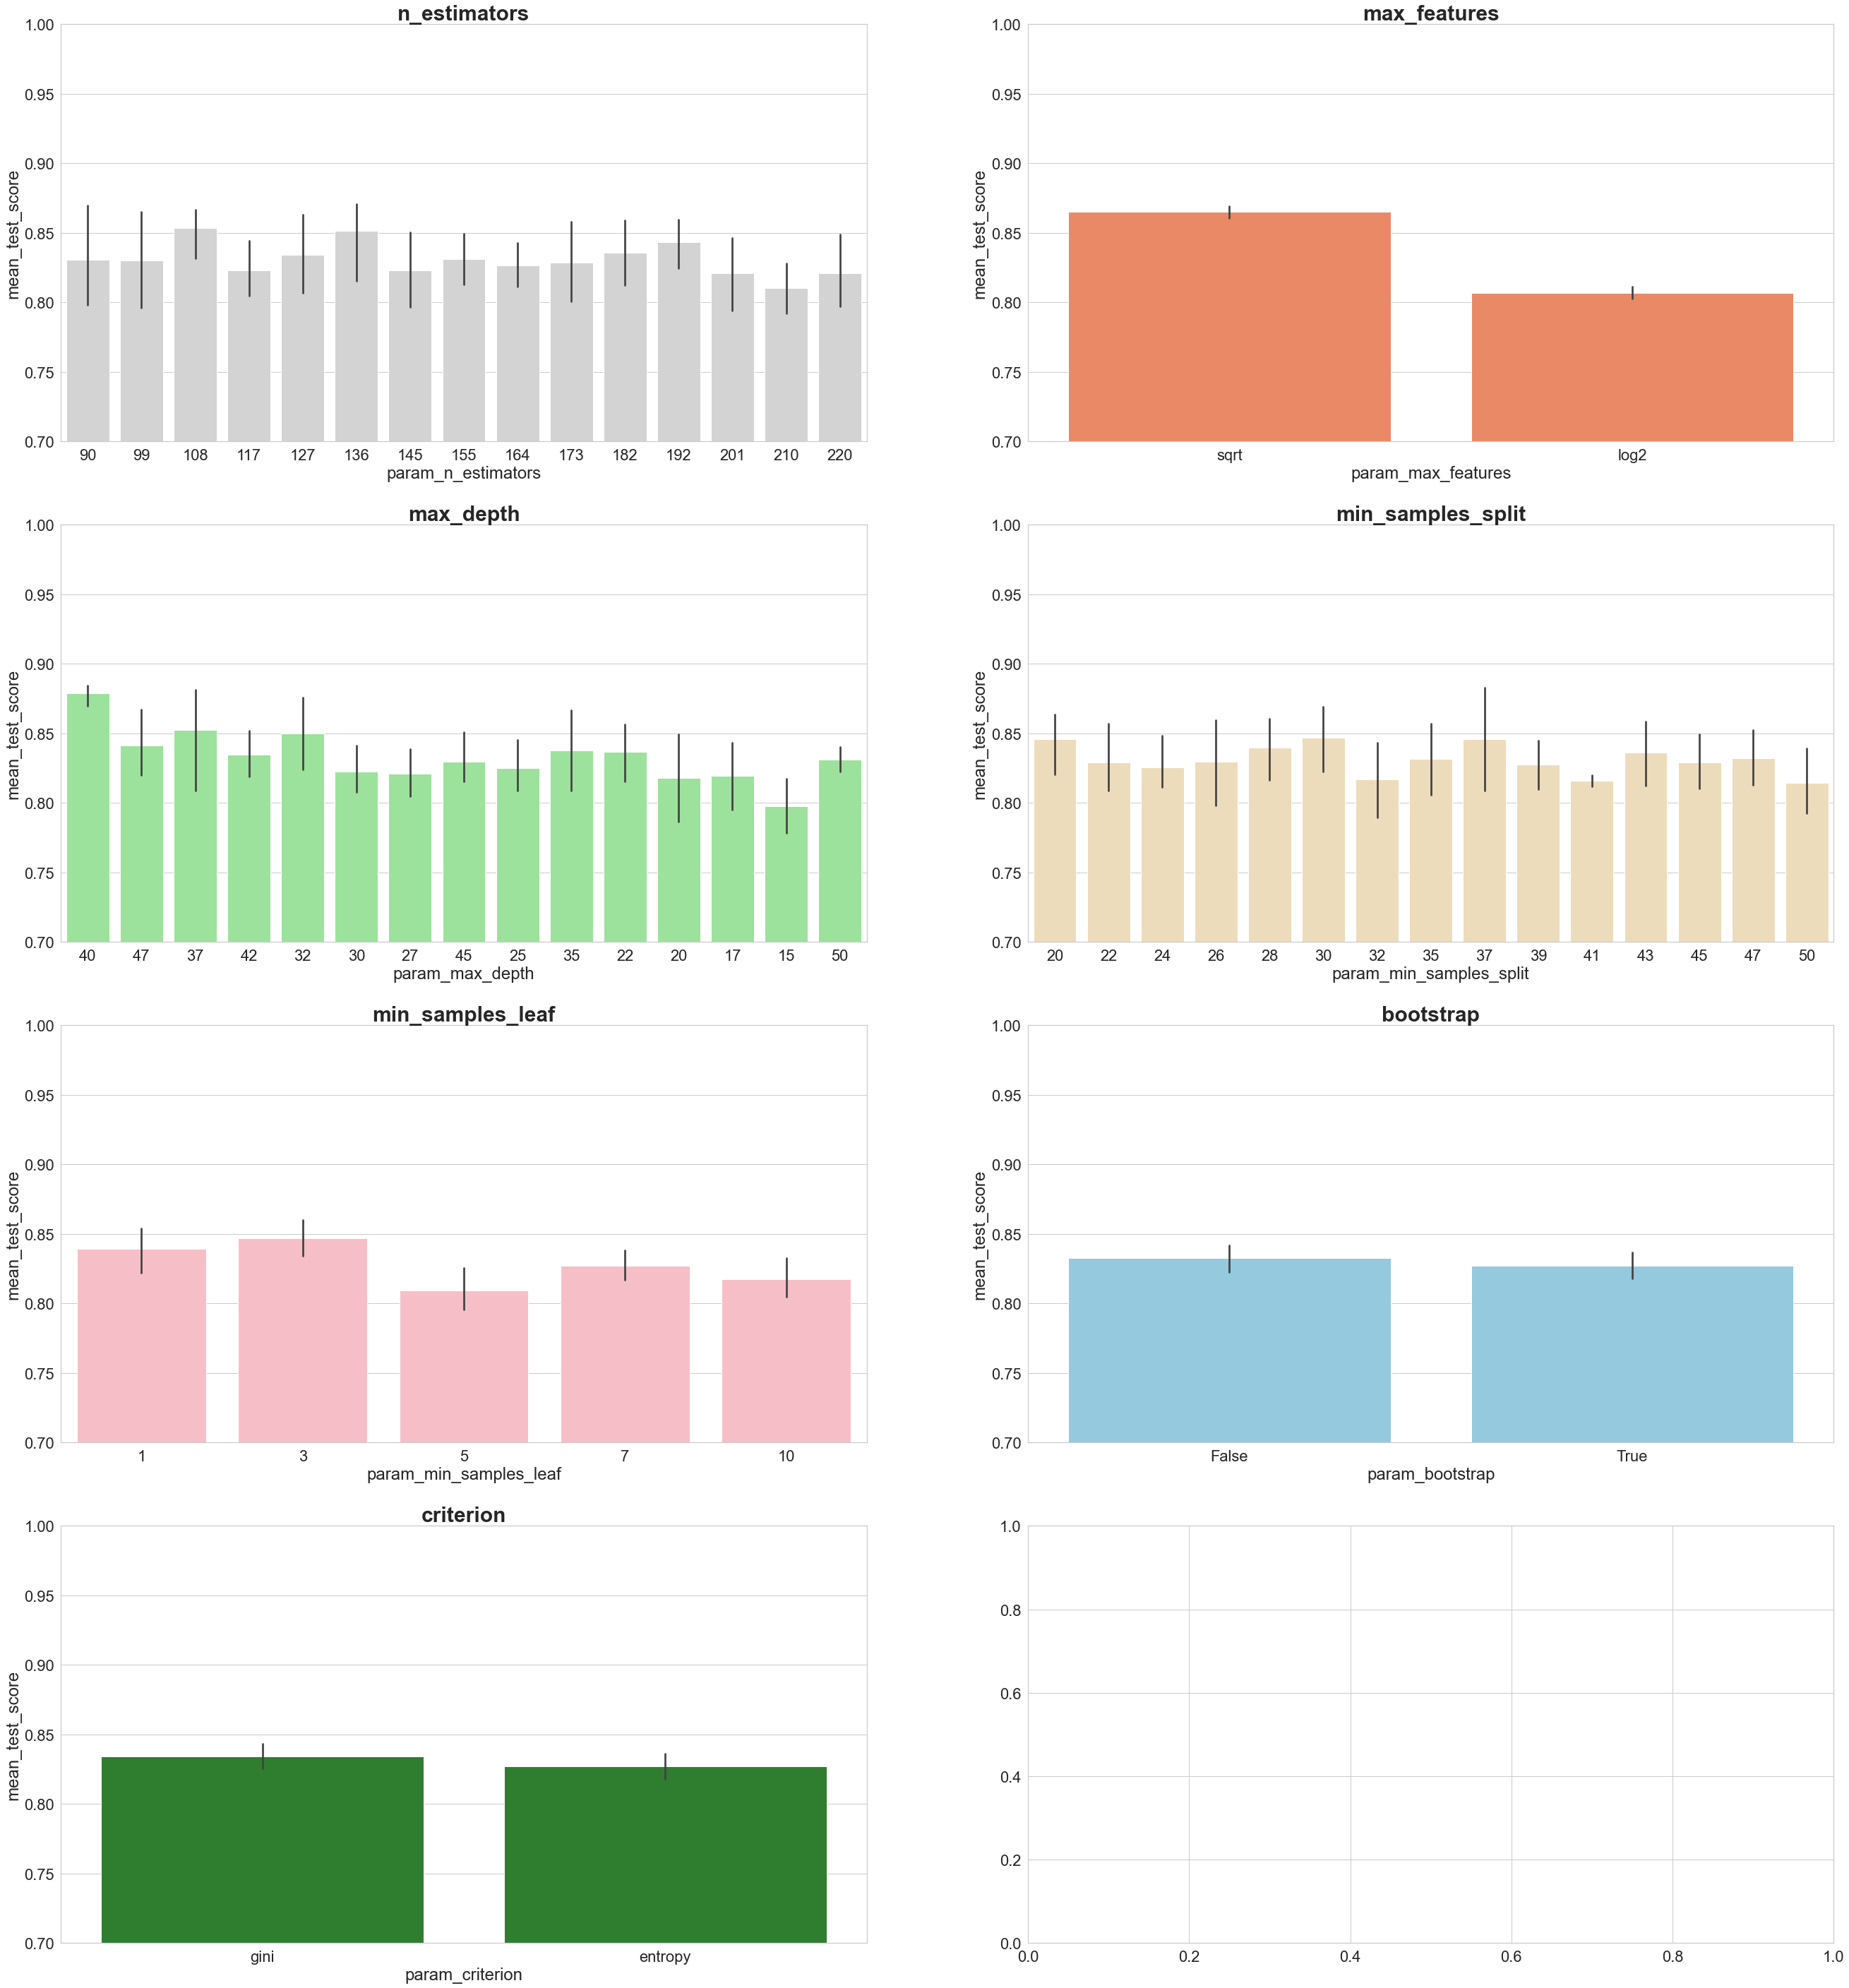

In [86]:
colors = ['lightgrey', 'coral', 'lightgreen', 'wheat', 'lightpink', 
          'skyblue', 'forestgreen', 'maroon', 'olivedrab']
params = ['param_' + x for x in list(param_dist.keys())]
ncols, nrows = 2, len(params) // 2 + len(params) % 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig.set_size_inches(45, 50)

for ind in range(len(params)):
    i = ind // ncols
    j = ind % ncols
    sns.barplot(x=params[ind], y='mean_test_score', data=rs_df, ax=axs[i, j], color=colors[ind])
    axs[i, j].set_ylim([.7, 1])
    axs[i, j].set_title(label=params[ind], size=30, weight='bold')

plt.show()

In [77]:
model = rs.best_estimator_
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=40,
                       max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=22, n_estimators=127)

In [134]:
def GetBestArgs(rs_df, param):
    a = rs_df.groupby(param).mean_test_score.mean().to_dict()
    srtd = [(a[key], key) for key in a.keys()]
    srtd.sort(key=lambda x: -x[0])
    srtd = [x[1] for x in srtd]
    return srtd

In [138]:
from sklearn.model_selection import GridSearchCV
best_n_estimators = GetBestArgs(rs_df, 'param_n_estimators')[:4]
best_max_features = GetBestArgs(rs_df, 'param_max_features')[:1]
best_max_depth = [None] + GetBestArgs(rs_df, 'param_max_depth')[:2]
best_min_samples_split = GetBestArgs(rs_df, 'param_min_samples_split')[:2]
best_min_samples_leaf = GetBestArgs(rs_df, 'param_min_samples_leaf')[:2]
best_bootstrap = [False, True]
param_grid = {
    'n_estimators' : best_n_estimators,
    'max_features' : best_max_features,
    'max_depth' : best_max_depth,
    'min_samples_split' : best_min_samples_split,
    'min_samples_leaf' : best_min_samples_leaf,
    'bootstrap' : best_bootstrap,
}
param_grid

{'n_estimators': [108, 136, 192, 182],
 'max_features': ['sqrt'],
 'max_depth': [None, 40, 37],
 'min_samples_split': [30, 37],
 'min_samples_leaf': [3, 1],
 'bootstrap': [False, True]}

In [139]:
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid, cv=3, verbose=1, n_jobs=1)
gs.fit(X_train, Y_train)
model = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'n_estimators': 136}

In [67]:
model = gs.best_estimator_
model.fit(X_train, Y_train)
gs.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 127}

In [20]:
# train the model
best_arg = 100
vectorizer, model = TrainRandomForestClassifier(train, n_estimators=best_arg)

In [56]:
# write model to file
if 'models' not in os.listdir():
    os.mkdir('models')
with open('./models/doc_classifyer-model', 'wb') as f:
    pickle.dump(model, f)
with open('./models/doc_classifyer-vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [80]:
with open('./models/doc_classifyer-model', 'rb') as f:
    model = pickle.load(f)
with open('./models/doc_classifyer-vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)

In [78]:
model

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=40,
                       max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=22, n_estimators=127)

In [89]:
# assess accuracy of the model
from sklearn.metrics import classification_report, accuracy_score
def ShowStatistics(model):
    precision, to_validate, confidence_level = CalculateAccuracy(test.copy(), 0.8)
    prediction = model.predict(vectorizer.transform(test['X']))
    print('Rows in test set: {}'.format(len(test)))
    print('Statistics:')
    print('Precision = {}%; Ratio to validate = {}%; at confidence level = {}'.format(precision, to_validate, confidence_level))
    print('Mean accuracy: {}%'.format(round(100 * accuracy_score(test['target'], prediction), 2)))
    print(classification_report(test['target'], prediction))
    
model1 = rs.best_estimator_
model1.fit(X_train, Y_train)
print('rand:', model1)
ShowStatistics(model1)
print()


rand: RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=30,
                       n_estimators=220)
Rows in test set: 4874
Statistics:
Precision = 76.08%; Ratio to validate = 21.77%; at confidence level = 0.8
Mean accuracy: 87.81%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.96      0.91      0.93       869
                                            ad-invoice-multi       0.94      0.67      0.78        87
                                          ad-statement-first       0.98      0.99      0.98      1160
                                          ad-statement-multi       0.99      0.86      0.92       139
                                                ad-upd-first       0.87      0.97      0.92       719
                                                ad-upd-multi       0.

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otr

In [140]:
model2 = gs.best_estimator_
model2.fit(X_train, Y_train)
print('grid:', model2)
ShowStatistics(model2)

grid: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=30, n_estimators=136)
Rows in test set: 4874
Statistics:
Precision = 75.44%; Ratio to validate = 22.53%; at confidence level = 0.8
Mean accuracy: 89.89%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.95      0.92      0.93       869
                                            ad-invoice-multi       0.95      0.72      0.82        87
                                          ad-statement-first       0.98      0.99      0.99      1160
                                          ad-statement-multi       0.99      0.90      0.94       139
                                                ad-upd-first       0.88      0.97      0.92       719
                                                ad-upd-multi       0.88      0.78      0.83       146
                        

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otr